# Compute Kernel for CellRank 

**RNA velocity** [Bergen et al., 2021](https://www.embopress.org/doi/full/10.15252/msb.202110282)  
Beyond the scope of computational modeling, the statistical power of the methods depends on the curvature in the phase portrait since a lack of curvature challenges current models to distinguish whether an up- or down-regulation is occurring. The overall curvature of deviation from the steady-state line in the phase portrait is mostly impacted by the ratios of splicing to degradation rates (Box 1), **indicating that statistical inference is limited to genes where splicing is faster or comparable to degradation, while a small ratio would yield straight lines rather than an interpretable curvature.**  

**MURK genes** [GitHub](https://github.com/mebarile/Gata1_Erythroid_kinetics/blob/main/Figure_6/search_and_rank_murk_human.ipynb)

In [ ]:
import scvelo as scv
import scanpy as sc
import scanpy.external as sce

import scipy
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os

In [ ]:
# rpy2 
os.environ['R_HOME'] = '/nobackup/peer/fdeckert/miniconda3/envs/r.4.1.0/lib/R'

In [ ]:
import warnings
warnings.simplefilter("ignore")

In [ ]:
sc.set_figure_params(figsize=(5, 5), dpi_save=1200, fontsize=10, frameon=False, color_map='magma')
scv.set_figure_params(figsize=(5, 5), dpi_save=1200, fontsize=10, frameon=False, color_map='magma')

In [ ]:
os.chdir('/research/peer/fdeckert/FD20200109SPLENO')

In [ ]:
# Plotting 
import rpy2.robjects as robjects
color_load = robjects.r.source('plotting_global.R')
color = dict()
for i in range(len(color_load[0])):
    color[color_load[0].names[i]] = {key : color_load[0][i].rx2(key)[0] for key in color_load[0][i].names}

In [ ]:
def set_color(adata, categories=color.keys()): 
    
    categories = [x for x in categories if x in list(adata.obs.columns)]
    for category in categories: 
        
        adata.obs[category] = pd.Series(adata.obs[category], dtype='category')
        
        keys = list(color[category].keys())
        keys = [x for x in keys if x in list(adata.obs[category])]

        adata.obs[category] = adata.obs[category].cat.reorder_categories(keys)
        adata.uns[category+'_colors'] = np.array([color[category].get(key) for key in keys], dtype=object)

# Import data 

In [ ]:
# Adata 
adata = sc.read_h5ad('data/BSA_0355_SM01_10x_SPLENO/ANALYSIS/pp.h5ad')
adata_v = sc.read_h5ad('data/BSA_0355_SM01_10x_SPLENO/ANALYSIS/velocyto.h5ad')

# Transfer velocyto matrices 

In [ ]:
obs_names = adata.obs_names
var_names = adata.var_names.intersection(adata_v.var_names)

In [ ]:
adata = adata[:, var_names]
adata_v = adata_v[obs_names, var_names]

In [ ]:
adata.X = adata_v.X
adata.layers = adata_v.layers

In [ ]:
# Set color
set_color(adata)

In [ ]:
# UMAP 
sc.pl.umap(sc.pp.normalize_total(adata.raw.to_adata(), copy=True), color=['leiden_cell_type_main', 'Cd34', 'Ly6a', 'Procr', 'Kit', 'Spi1', 'Klf1', 'Gata1', 'Gata2', 'Nfe2', 'Fli1', 'Pf4', 'Mpl', 'Gfi1', 'Cebpa', 'Irf8', 'Elane', 'Mcpt8', 'Prss34', 'Cd74', 'Csf1r', 'Car2', 'Dntt', 'Flt3', 'Lyz2'], legend_loc='on data', ncols=5, size=50, use_raw=False)

# Helper function

In [345]:
#######################
### Velocity kernel ###
#######################
def vk_workflow(adata, suffix, gene_subset=None, compute=False):
    
    if compute: 
        
        if gene_subset is None: 
            # Subset genes 
            adata = adata[:, (adata.X>=1).sum(axis=0)>=1].copy()

            # Set filtered var names 
            var_names = scv.pp.filter_and_normalize(adata, min_shared_counts=20, subset_highly_variable=False, n_top_genes=None, log=False, copy=True).var_names

            # Normalize X, spliced, and unspliced
            sc.pp.normalize_total(adata, layers=['spliced', 'unspliced'])

            # Subset by var names filter
            adata = adata[:, var_names].copy()

            # First-/second-order moments are computed for each cell across its nearest neighbors
            scv.pp.moments(adata, n_pcs=None, n_neighbors=None)
            scv.tl.recover_dynamics(adata, n_jobs=48)

            # Estimates velocities in a gene-specific manner
            scv.tl.velocity(adata, mode='dynamical')
            
            # Velocity graph 
            scv.tl.velocity_graph(adata, n_jobs=48)

            # Velocity pseudotime 
            scv.tl.velocity_pseudotime(adata)
            
            # Terminal and root cells 
            scv.tl.recover_latent_time(adata)
            
            # Differential kinetics for top genes
            top_genes = adata.var['fit_likelihood'][adata.var['fit_likelihood'] >= 0.1].sort_values(ascending=False).index
            scv.tl.differential_kinetic_test(adata, var_names=top_genes, groupby='leiden_cell_type_main')
            
        else: 
            
            # Subset to genes 
            adata = adata[:, gene_subset].copy()
            
            # Velocity graph 
            scv.tl.velocity_graph(adata, n_jobs=48, gene_subset=gene_subset)
            
            # Velocity confidence 
            scv.tl.velocity_confidence(adata)
            
            # Terminal and root cells 
            scv.tl.terminal_states(adata)
            
            # Terminal and root cells 
            scv.tl.recover_latent_time(adata)
            
            # Velocity pseudotime 
            scv.tl.velocity_pseudotime(adata)
            
        # CellRank kernel 
        from cellrank.kernels import VelocityKernel
        vk = VelocityKernel(adata)
        
        vk.write('data/BSA_0355_SM01_10x_SPLENO/ANALYSIS/cellrank/kernel/vk'+suffix+'.pickle', write_adata=True)
        
    else: 
        
        from cellrank.kernels import VelocityKernel
        vk = VelocityKernel.read(fname='data/BSA_0355_SM01_10x_SPLENO/ANALYSIS/cellrank/kernel/vk'+suffix+'.pickle')
        
    return vk

In [ ]:
###########################
### Connectivity kernel ###
###########################
def ck_workflow(adata, suffix, compute=True):
    
    if compute: 
        
        # CellRank kernel 
        from cellrank.kernels import ConnectivityKernel
        ck = ConnectivityKernel(adata)
        
        ck.write('data/BSA_0355_SM01_10x_SPLENO/ANALYSIS/cellrank/kernel/ck'+suffix+'.pickle', write_adata=True)
        
    else: 
        
        from cellrank.kernels import ConnectivityKernel
        ck = ConnectivityKernel.read(fname='data/BSA_0355_SM01_10x_SPLENO/ANALYSIS/cellrank/kernel/ck'+suffix+'.pickle')
        
    return ck

In [ ]:
#######################
### Palantir kernel ###
#######################
def pk_workflow(adata, suffix, s_genes, t_genes, compute=True):
    
    if compute:
        
        # Use original data
        adata = adata.raw.to_adata()
        adata.raw = adata
        
        # Subset genes 
        adata = adata[:, (adata.X>=1).sum(axis=0)>=1].copy()
        
        # Normalize
        sc.pp.normalize_total(adata)
        
        # PCA
        sc.pp.pca(adata, n_comps=300)
        
        # Palantir diffusion maps based on PCA
        sce.tl.palantir(adata, n_components=10, knn=30)

        # Compute starting cell
        for k, v in s_genes.items():
            sc.tl.score_genes(adata, v, score_name='t_score_'+ k.lower())
            t_cell=adata.obs['t_score_'+ k.lower()].idxmax()
            s_genes[k] = t_cell
        s_id = pd.Series(list(s_genes.keys()), list(s_genes.values()))

        # Compute terminal state cells
        for k, v in t_genes.items():
            sc.tl.score_genes(adata, v, score_name='t_score_'+ k.lower())
            t_cell=adata.obs['t_score_'+ k.lower()].idxmax()
            t_genes[k] = t_cell
        t_id = pd.Series(list(t_genes.keys()), list(t_genes.values()))

        adata.obs = adata.obs.join(pd.DataFrame({'pt_cells':pd.concat([s_id, t_id]).tolist()}, index=pd.concat([s_id, t_id]).index), how='left')
        
        # Palantir results 
        pr_res = sce.tl.palantir_results(
            adata,
            early_cell=s_id.index[0], 
            terminal_states=t_id, 
            ms_data='X_palantir_multiscale',
            num_waypoints=500, 
            use_early_cell_as_start=False
        )
        
        # Get pseudotime 
        adata.obs['ppt_pseudotime'] = pr_res.pseudotime
        
        # Use original data
        adata = adata.raw.to_adata()
        adata.raw = adata

        # CellRank kernel 
        from cellrank.kernels import PseudotimeKernel
        pk = PseudotimeKernel(adata, time_key='ppt_pseudotime')

        pk.write('data/BSA_0355_SM01_10x_SPLENO/ANALYSIS/cellrank/kernel/pk'+suffix+'.pickle', write_adata=True)
    
    else: 
        
        from cellrank.kernels import PseudotimeKernel
        pk = PseudotimeKernel.read(fname='data/BSA_0355_SM01_10x_SPLENO/ANALYSIS/cellrank/kernel/pk'+suffix+'.pickle')
    
    return pk

# Kernel Progenitor

In [ ]:
cell_type_prog = [
    
    'Meg', 
    'MEP', 
    'ProEB', 
    'EB I',
    'EB II', 
    'EB III'
    
]

In [ ]:
mep_genes = pd.read_csv('result/dea/scRNAseq/wilcox/velocity_mep.csv', index_col=0)['genes']

## Kernel Progenitor (Baseline) 

In [303]:
# Subset anndata 
adata_i = adata.copy()
adata_i = adata_i[(adata_i.obs.leiden_cell_type_main.isin(cell_type_prog)).values & (adata_i.obs.infection=='Baseline').values].copy()

In [304]:
# Neighborgraph
sc.pp.neighbors(adata_i, n_neighbors=30, use_rep='latent')

In [317]:
vk_1 = vk_workflow(adata=adata_i, suffix='_prog_baseline_1', compute=False)
vk_2 = vk_workflow(adata=vk_1.adata, suffix='_prog_baseline_2', compute=False, gene_subset=top_genes)
ck = ck_workflow(adata=adata_i, suffix='_prog_baseline', compute=False)
pk = pk_workflow(adata=adata_i, suffix='_prog_baseline', compute=False, s_genes=dict(Start=['Cd34', 'Kit', 'Gata2']), t_genes=dict(Ery=['Hbb-bt'], Meg=['Pf4']))

## DEV 

In [347]:
# Subset by velocity genes
adata_v = vk_1.adata
v_genes = adata_v.var.velocity_genes
adata_v = adata_v[:, v_genes].copy()

In [348]:
# Get top likelihood fit genes
top_genes = adata_v.var['fit_likelihood'][adata_v.var['fit_likelihood'] >= 0.1].sort_values(ascending=False).index

In [349]:
# Get diff kinetics genes
scv.tl.differential_kinetic_test(adata_v, var_names=top_genes, groupby='leiden_cell_type_main')
dk_genes = scv.get_df(adata_v[:, top_genes], ['fit_diff_kinetics', 'fit_pval_kinetics'], precision=2).index

testing for differential kinetics
    finished (0:01:29) --> added 
    'fit_diff_kinetics', clusters displaying differential kinetics (adata.var)
    'fit_pvals_kinetics', p-values of differential kinetics (adata.var)


In [350]:
gene_subset = list(set(top_genes)-set(dk_genes))

computing velocity graph (using 48/48 cores)
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


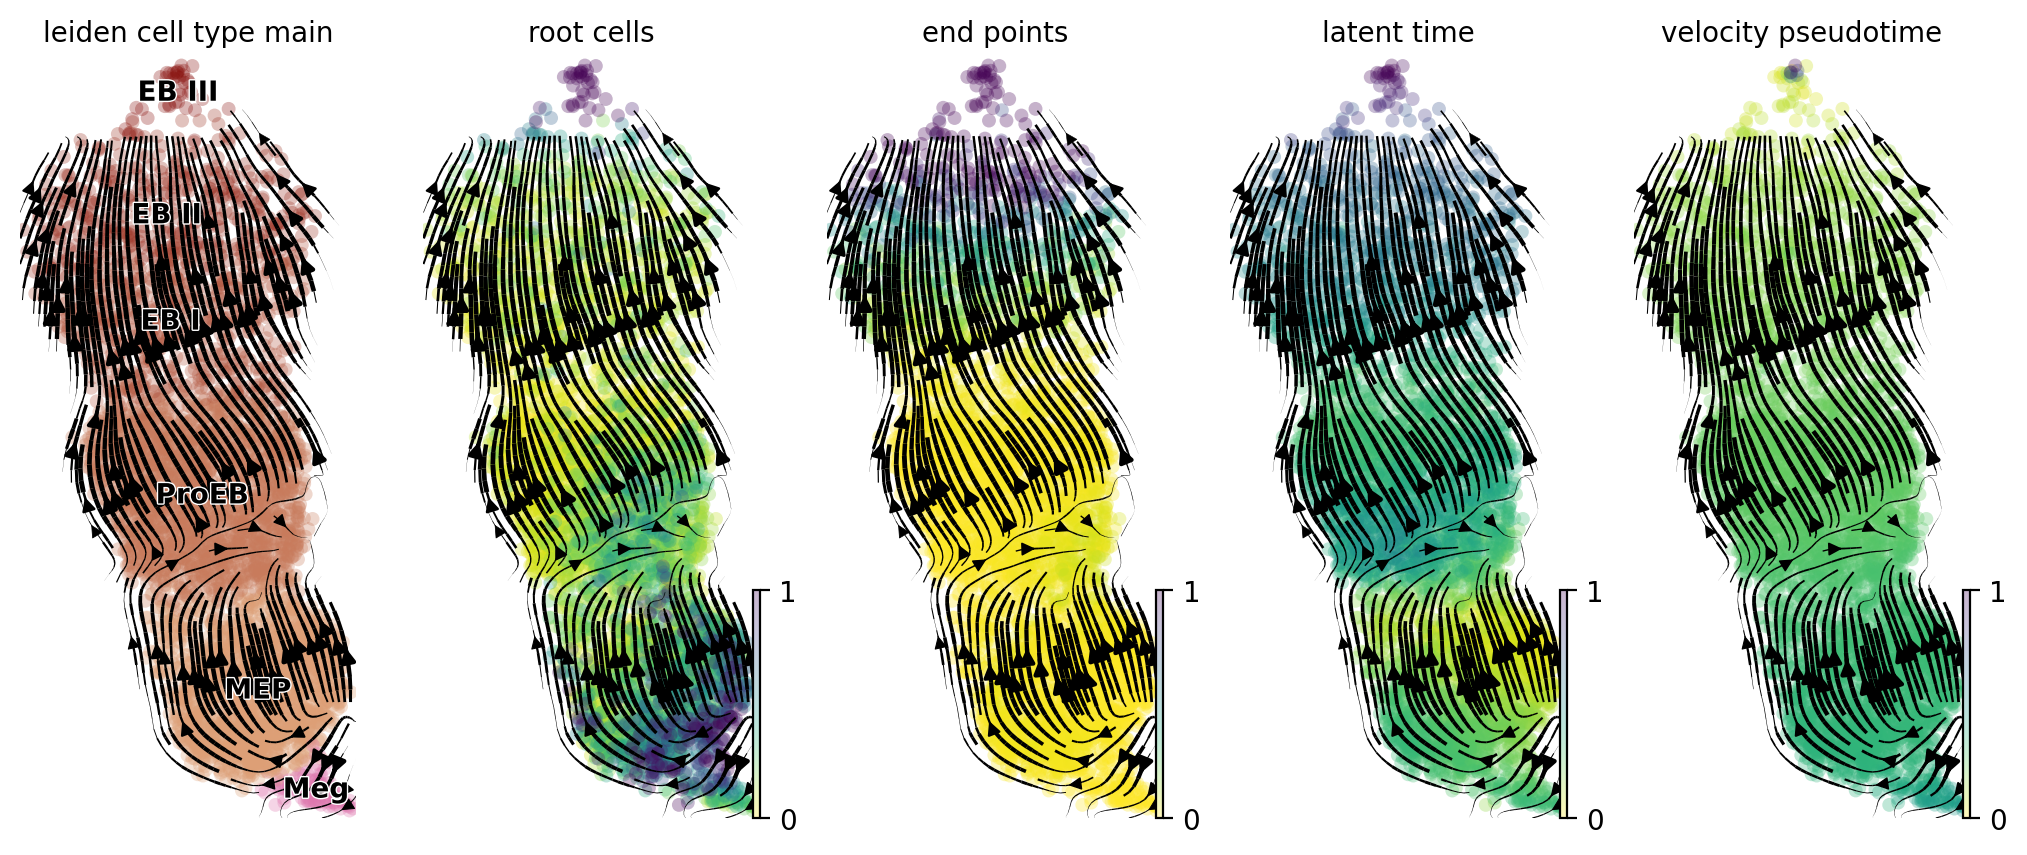

In [351]:
vk_2 = vk_workflow(adata=vk_1.adata, suffix='_prog_baseline_2', compute=True, gene_subset=gene_subset)
scv.pl.velocity_embedding_stream(vk_2.adata, basis='X_umap', color=['leiden_cell_type_main', 'root_cells', 'end_points', 'latent_time', 'velocity_pseudotime'], legend_loc='on data', ncols=6, size=100, use_raw=False)

computing velocity graph (using 48/48 cores)
    finished (0:00:28) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


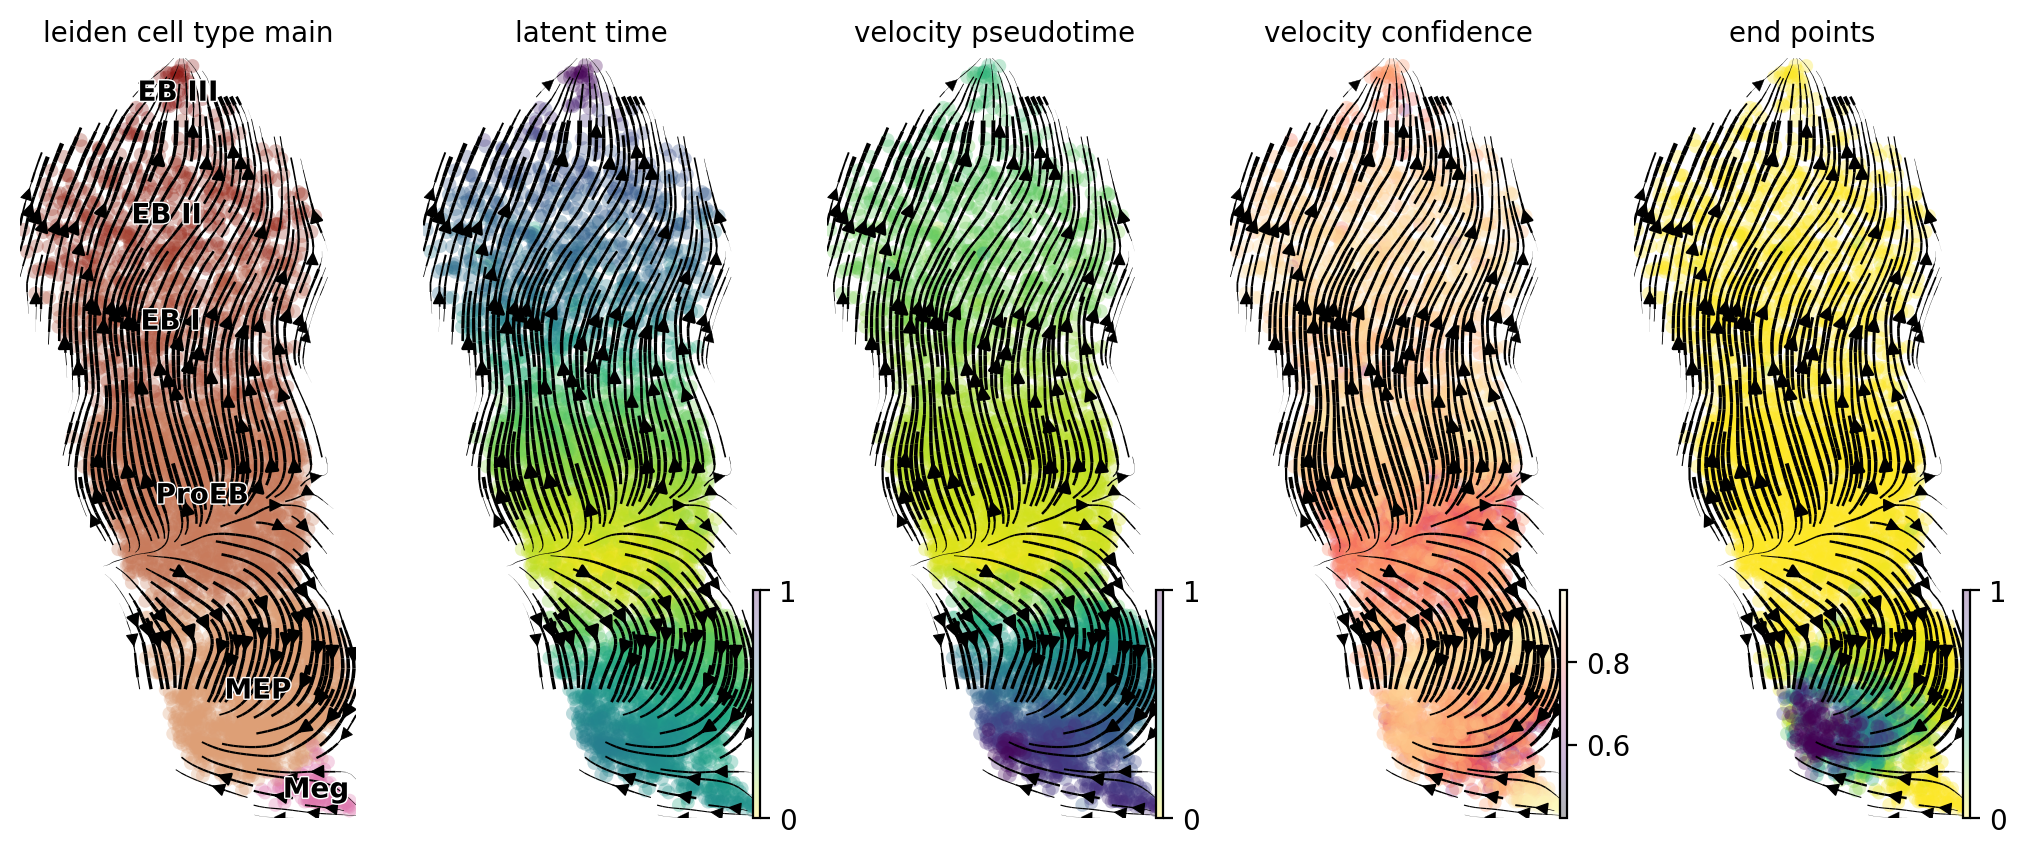

In [352]:
vk_2 = vk_workflow(adata=vk_1.adata, suffix='_prog_baseline_2', compute=True, gene_subset=gene_subset)
scv.pl.velocity_embedding_stream(vk_1.adata, basis='X_umap', color=['leiden_cell_type_main', 'latent_time', 'velocity_pseudotime', 'velocity_confidence', 'end_points'], legend_loc='on data', ncols=6, size=100, use_raw=False)

## DEV 

In [ ]:
sc.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)
scv.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)

In [ ]:
scv.pl.velocity_embedding_stream(vk_1.adata, basis='X_umap', color=['leiden_cell_type_main', 'latent_time', 'velocity_pseudotime', 'velocity_confidence', 'root_cells', 'end_points'], legend_loc='on data', ncols=6, size=100, use_raw=False)

In [ ]:
scv.pl.velocity_embedding_stream(vk_2.adata, basis='X_umap', color=['leiden_cell_type_main', 'latent_time', 'velocity_pseudotime', 'velocity_confidence', 'root_cells', 'end_points'], legend_loc='on data', ncols=6, size=100, use_raw=False)

In [ ]:
sc.pl.umap(pk.adata, color=['leiden_cell_type_main', 'ppt_pseudotime', 'pt_cells', 't_score_start', 't_score_ery', 't_score_meg'], legend_loc='on data', ncols=6, size=100, use_raw=False)

## Kernel Progenitor (CpG) 

In [ ]:
# Subset anndata 
adata_i = adata.copy()
adata_i = adata_i[(adata_i.obs.leiden_cell_type_main.isin(cell_type_prog)).values & (adata_i.obs.infection=='CpG').values].copy()

In [ ]:
# Neighborgraph
sc.pp.neighbors(adata_i, n_neighbors=30, use_rep='latent')

In [ ]:
vk_1 = vk_workflow(adata=adata_i, suffix='_prog_cpg_1', compute=False)
vk_2 = vk_workflow(adata=vk_1.adata, suffix='_prog_cpg_2', compute=True, gene_subset=list(set(vk_1.adata.var_names[vk_1.adata.var.velocity_genes])-set(mep_genes)))
ck = ck_workflow(adata=adata_i, suffix='_prog_cpg', compute=False)
pk = pk_workflow(adata=adata_i, suffix='_prog_cpg', compute=False, s_genes=dict(Start=['Cd34', 'Kit', 'Gata2']), t_genes=dict(Ery=['Hbb-bt'], Meg=['Pf4']))

In [ ]:
sc.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)
scv.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)

In [ ]:
scv.pl.velocity_embedding_stream(vk_1.adata, basis='X_umap', color=['leiden_cell_type_main', 'latent_time', 'velocity_pseudotime', 'velocity_confidence', 'root_cells', 'end_points'], legend_loc='on data', ncols=6, size=100, use_raw=False)

In [ ]:
scv.pl.velocity_embedding_stream(vk_2.adata, basis='X_umap', color=['leiden_cell_type_main', 'latent_time', 'velocity_pseudotime', 'velocity_confidence', 'root_cells', 'end_points'], legend_loc='on data', ncols=6, size=100, use_raw=False)

In [ ]:
sc.pl.umap(pk.adata, color=['leiden_cell_type_main', 'ppt_pseudotime', 'pt_cells', 't_score_start', 't_score_ery', 't_score_meg'], legend_loc='on data', ncols=6, size=100, use_raw=False)